# Hardware Compatible Gradients

This notebook compares the performance of finite differences and paramater shift gradient computations.
These gradients are hardware compatible although, they run more slowly than backpropagation.
The nonlocality optimization is performed for the 6-local chain network.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import time

from context import qnetvo as QNopt

In [2]:
def bell_state_local_RY(settings, wires):
    qml.Hadamard(wires[0])
    qml.CNOT(wires=wires[0:2])
        
    qml.RY(settings[0], wires=wires[0])
    qml.RY(settings[1], wires=wires[1])

def static_nlocal_prepare_nodes(n):
    return [QNopt.PrepareNode(1, [2*i, 2*i + 1], bell_state_local_RY, 2) for i in range(n)]

def local_RY_measure_nodes(n):
    meas_nodes = [QNopt.MeasureNode(2, 2, [0], QNopt.local_RY, 1)]
    meas_nodes.extend([
        QNopt.MeasureNode(2, 2, [2*i + 1, 2*i + 2], QNopt.local_RY, 2) for i in range(0,n-1)
    ])
    meas_nodes.append(QNopt.MeasureNode(2, 2, [2*n-1], QNopt.local_RY, 1))
    
    return meas_nodes

## Comparison Between Gradient Methods for n-Local Chain Optimizations

In [3]:
n = 6
prep_nodes = static_nlocal_prepare_nodes(n)
meas_nodes = local_RY_measure_nodes(n)

nlocal_ansatz = QNopt.NetworkAnsatz(prep_nodes, meas_nodes)

### 6-Local Chain Optimization with BackPropagation

In [4]:
%%time

backprop_cost = QNopt.nlocal_chain_cost_22(nlocal_ansatz, diff_method="backprop")

np.random.seed(1)
backprop_settings = nlocal_ansatz.rand_scenario_settings()

backprop_opt_dict = QNopt.gradient_descent(
    backprop_cost,
    backprop_settings,
    num_steps=15,
    step_size=0.8,
    sample_width = 3
)

print("max score : ", backprop_opt_dict["opt_score"])

iteration :  0 , score :  0.2910119273912153
iteration :  3 , score :  1.170438972976621
iteration :  6 , score :  1.3713732007878927
iteration :  9 , score :  1.4082694211302902
iteration :  12 , score :  1.4134015966515074
max score :  1.4141033563290029
CPU times: user 4.76 s, sys: 207 ms, total: 4.97 s
Wall time: 5.06 s


### 6-Local Chain Optimization with Parameter-Shift Rule

In [5]:
%%time

param_shift_cost = QNopt.nlocal_chain_cost_22(nlocal_ansatz, diff_method="parameter-shift")

np.random.seed(1)
param_shift_settings = nlocal_ansatz.rand_scenario_settings()

param_shift_opt_dict = QNopt.gradient_descent(
    param_shift_cost,
    param_shift_settings,
    num_steps=15,
    step_size=0.8,
    sample_width = 3
)

print("max score : ", param_shift_opt_dict["opt_score"])

iteration :  0 , score :  0.2910119273912153
iteration :  3 , score :  1.1704389729766205
iteration :  6 , score :  1.3713732007878923
iteration :  9 , score :  1.40826942113029
iteration :  12 , score :  1.4134015966515068
max score :  1.4141033563290024
CPU times: user 24.5 s, sys: 245 ms, total: 24.7 s
Wall time: 24.8 s


### 6-Local Chain Optimization with Finite-Differences Rule

In [6]:
%%time

finite_diff_cost = QNopt.nlocal_chain_cost_22(nlocal_ansatz, diff_method="finite-diff")

np.random.seed(1)
finite_diff_settings = nlocal_ansatz.rand_scenario_settings()

finite_diff_opt_dict = QNopt.gradient_descent(
    finite_diff_cost,
    finite_diff_settings,
    num_steps=15,
    step_size=0.8,
    sample_width = 3
)

print("max score : ", finite_diff_opt_dict["opt_score"])

iteration :  0 , score :  0.2910119273912153
iteration :  3 , score :  1.1704389689194263
iteration :  6 , score :  1.371373198239204
iteration :  9 , score :  1.4082694207236917
iteration :  12 , score :  1.4134015964572182
max score :  1.414103356320544
CPU times: user 13.3 s, sys: 147 ms, total: 13.4 s
Wall time: 13.5 s


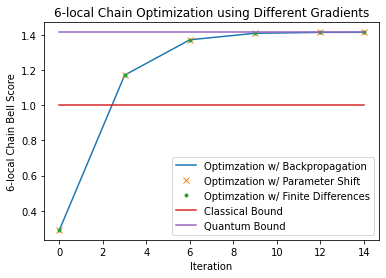

In [7]:
num_samples = len(backprop_opt_dict["samples"])

plt.plot(backprop_opt_dict["samples"], backprop_opt_dict["scores"], label = "Optimzation w/ Backpropagation")
plt.plot(param_shift_opt_dict["samples"], param_shift_opt_dict["scores"], "x", label = "Optimzation w/ Parameter Shift", )
plt.plot(finite_diff_opt_dict["samples"], finite_diff_opt_dict["scores"], ".", label = "Optimzation w/ Finite Differences")


plt.plot(backprop_opt_dict["samples"], [1]*num_samples, label = "Classical Bound")
plt.plot(backprop_opt_dict["samples"], [2/np.sqrt(2)]*num_samples, label = "Quantum Bound")
plt.title(r"6-local Chain Optimization using Different Gradients")
plt.xlabel("Iteration")
plt.ylabel(r"6-local Chain Bell Score")
plt.legend()
plt.show()